
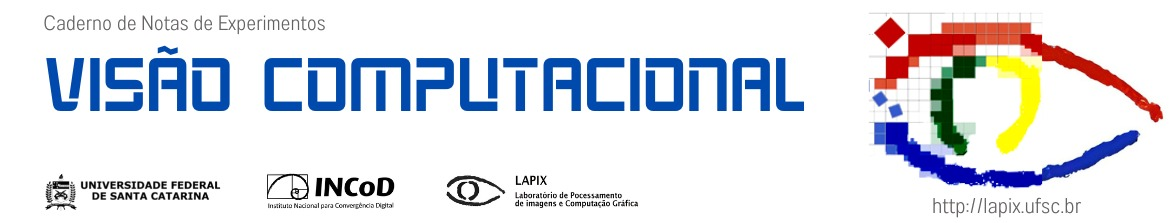






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/04.1.Convolu%C3%A7%C3%A3o%20Simples%20para%20Cria%C3%A7%C3%A3o%20de%20Filtros.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>


# 04.1.Convolução Simples para Criação de Filtros

A operação de convolução - modificar ponto a ponto a extensão de um sinal maior através de uma operação algébrica matricial com um sinal menor mas de dimensionalidade igual (o filtro de convolução) - é uma das formas mais comuns e recorrentes de processamento de sinais e imagens, sejam sinais unidimensionais ou imagens bi-, tri- ou tetra-dimensionais. 

Neste caderno de notas aqui vamos ver filtros de convolução bi-dimensionais tipicamente utilizados para o preparo e a melhoria de imagens. Depois que você aprender os princípios gerais da filtragem por convolução você vai ser capaz inclusive de imaginar filtros customizados para aplicações específicas que você venha a encontrar. Nos exercícios abaixo nós vamos porém nos a ter a um conjunto de filtros clássicos que são extremamente úteis principalmente para a melhoria da qualidade de imagens com ruído.

### Common Initializations
GPU and PATH

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    ![ -d vision ] || !git clone https://github.com/awangenh/vision

else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

Running on Google Colab =  False


In [2]:
import cv2
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import copy
from PIL import Image
import numpy as np

# Simple Filters

This section discusses simple filters. Some of these filter employ simple mathematical operations, such as mean or media, other employ simples convolutions, such as Gaussian, low-pass, high-pass or band-pass filters.

When we work with image filters, we usually work with concepts of stride and window size such the filtering processing occurs locally window by window, they same will be applied later on convolutional neural networks. In this example, I want to show you what they exactly it means to split an image into multiple parts, which can call patches. The filters are them applied to these patches.

In [3]:
im = cv2.imread("../data/car-01.jpg")[..., ::-1]
im.shape

(675, 900, 3)

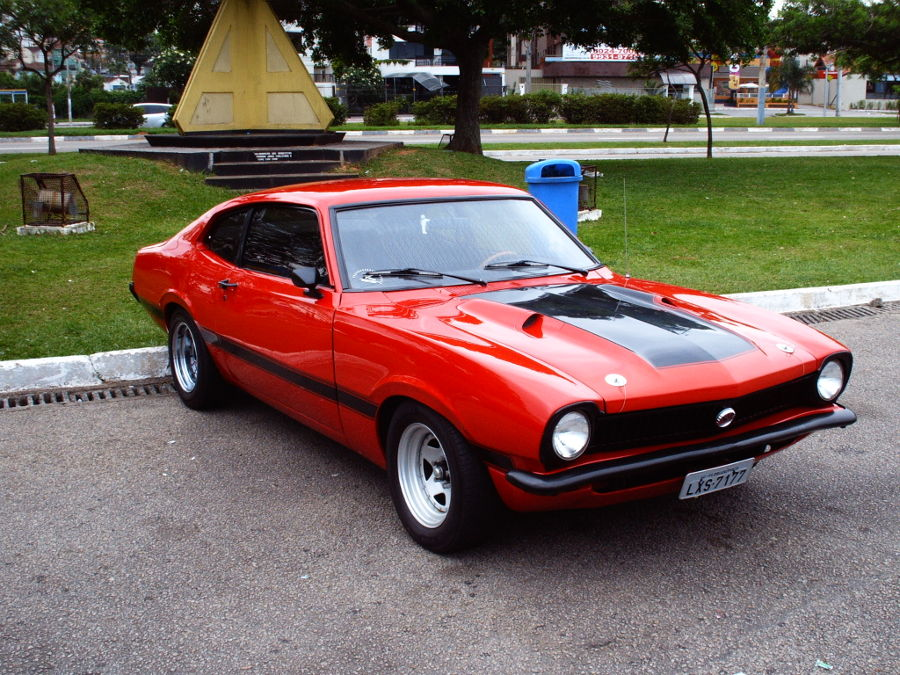

In [4]:
Image.fromarray(im)

In [5]:
# Resize image for fast example
im2 = cv2.resize(im, (180, 135))
print(im2.shape)


patches = []

stride = 20
ws = 50 # window-size
h, w = im2.shape[:2]

row_patches = []
for i in np.arange(0, h - ws, stride):
    
    col_patches = []
    for j in np.arange(0, w - ws, stride): 
        patch = im2[i:i+ws, j:j+ws]
        col_patches.append(patch)
    
    row_patches.append(col_patches)

(135, 180, 3)


Here, we have the image split into multiple patches, then, the filter operation are then applied only over this area.

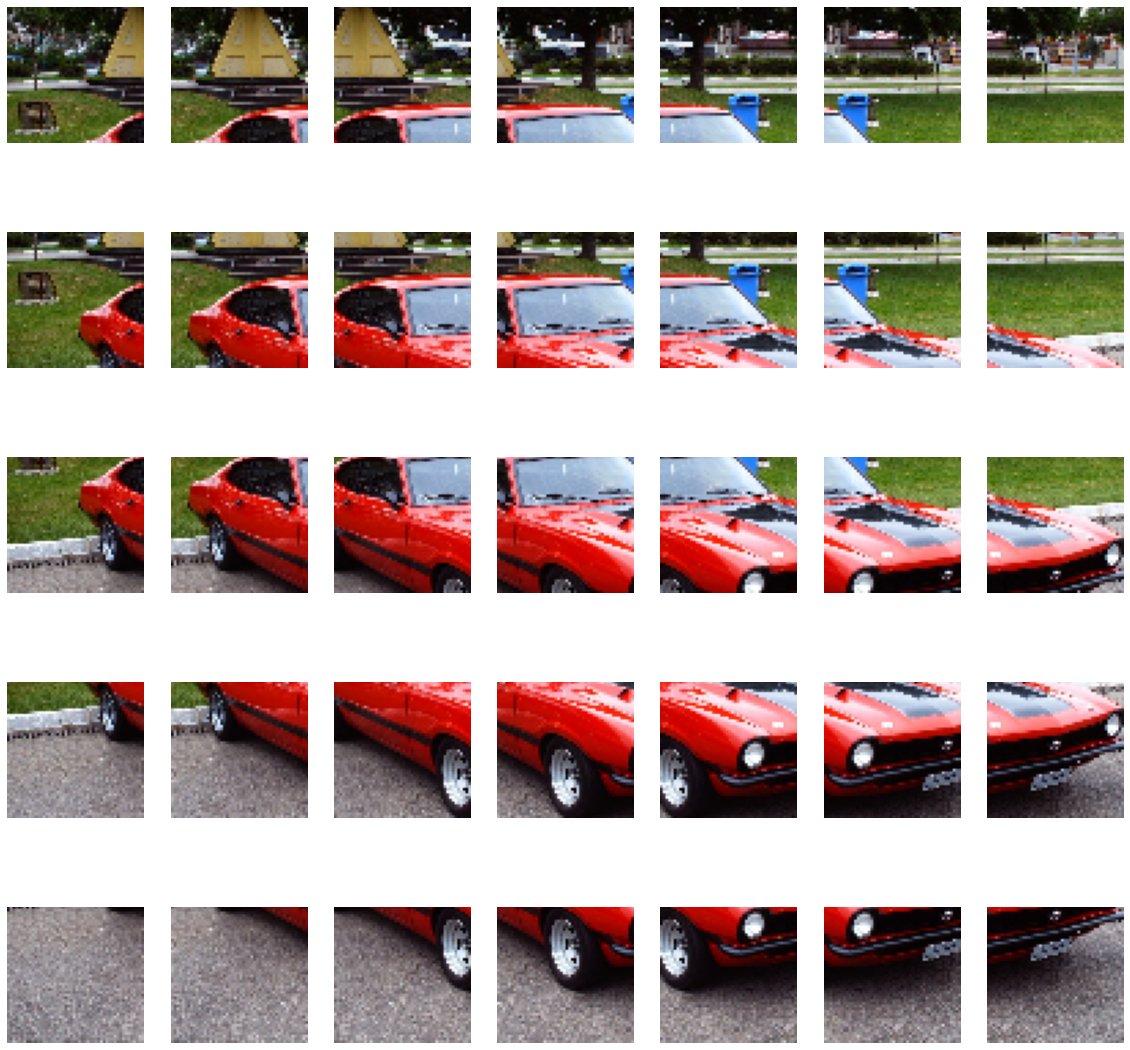

In [6]:
nrows, ncols = len(row_patches), len(row_patches[0])
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 4*nrows))
[a.set_axis_off() for a in axs.ravel()]

for i, rp in enumerate(row_patches):
    for j, patch in enumerate(rp):
        axs[i, j].imshow(patch)

# Mean Filter

A basic example is to compute the mean over this area. This is called the mean filter.

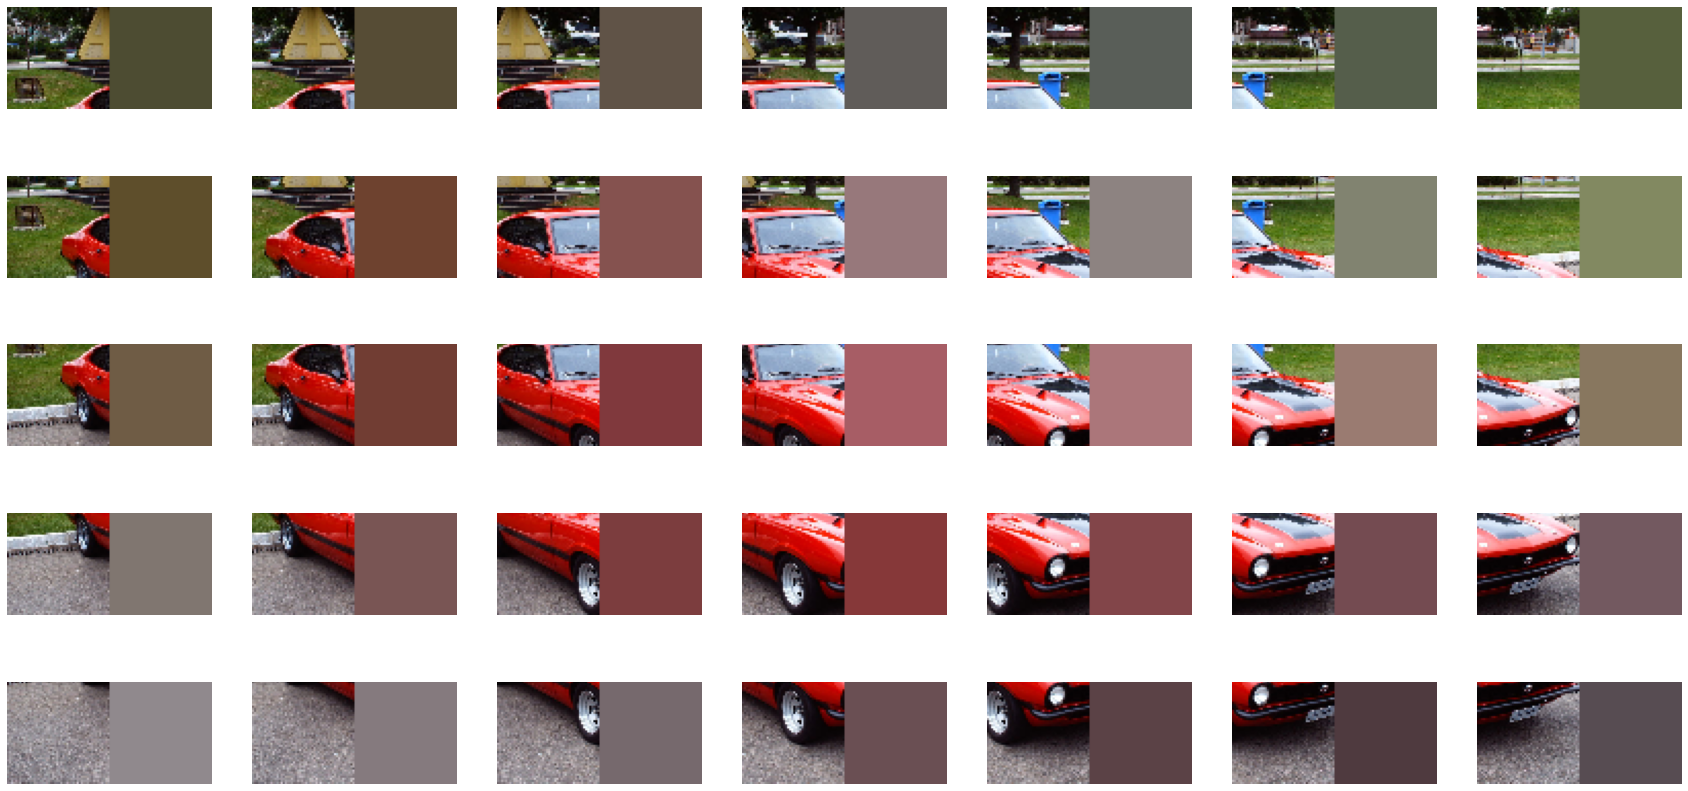

In [7]:
nrows, ncols = len(row_patches), len(row_patches[0])
fig, axs = plt.subplots(nrows, ncols, figsize=(30, 3*nrows))
[a.set_axis_off() for a in axs.ravel()]

for i, rp in enumerate(row_patches):
    for j, patch in enumerate(rp):
        avg = np.mean(patch, axis=0)
        avg = np.mean(avg, axis=0)
        avg = np.round(avg).astype(np.uint8)
        avg = avg[None, None]
        hp, wp = patch.shape[:2]
        avg = avg.repeat(hp, axis=0).repeat(wp, axis=1)
        avg = np.concatenate([patch, avg], axis=1)
        axs[i, j].imshow(avg)

Now, we apply this over the original image and to see the actual results. The `mean` operation here would to the same than applying a conv2D filter using a kernel filled with ones.

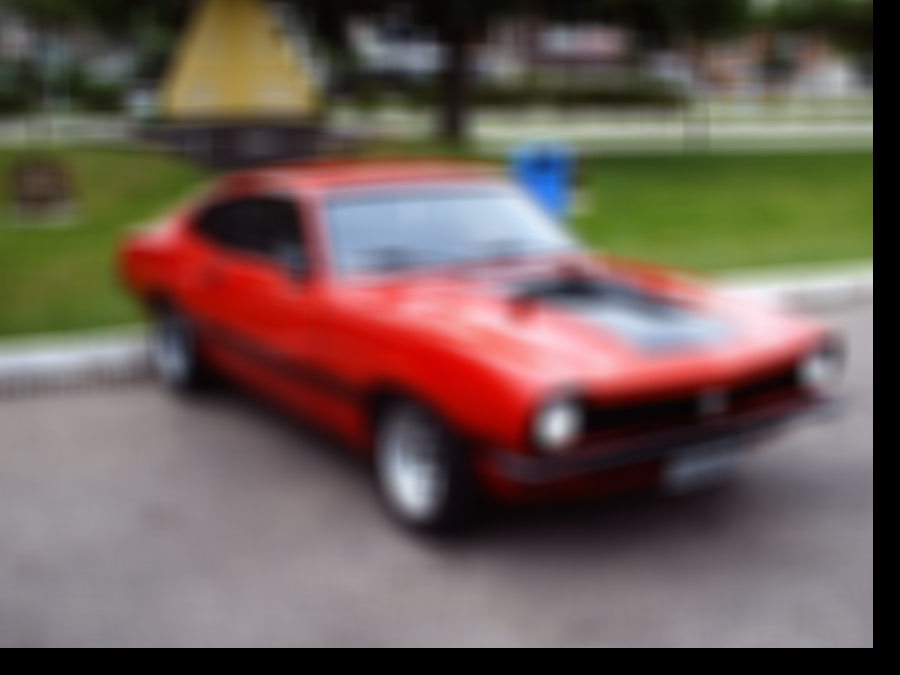

In [8]:
patches = []

stride = 1
ws = 27
h, w = im.shape[:2]

out = np.zeros_like(im)
for i in np.arange(0, h - ws, stride):
    for j in np.arange(0, w - ws, stride): 
        patch = im[i:i+ws, j:j+ws]
        avg = patch.mean(0).mean(0)
        avg = avg.round().astype(np.uint8)
        out[i, j] = avg

        
Image.fromarray(out)

### Filters in OpenCV

OpenCV implements a huge palette of filters. You'll find some documentation on these pages:
- Methods: https://docs.opencv.org/3.4.1/d4/d86/group__imgproc__filter.html
- Explanations: https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html

We will demonstrate a few here. OpenCV also allows you to develop any custom convolutional filter using  the OpenCV function [filter2D()](https://docs.opencv.org/3.4.3/d5/df1/group__imgproc__hal__functions.html#ga42c2468ab3a1238fbf48458c57169081) to create your own linear filters. Here's an official tutorial: https://docs.opencv.org/3.4.3/d4/dbd/tutorial_filter_2d.html.

Mathematical Morphology filters we will handle in a separate, specific notebook.

The **Median Blur** smoothes an image using the median filter with the $(\texttt{ksize} \times \texttt{ksize})$ aperture. Each channel of a multi-channel image is processed independently. Parameters:	

    src – input 1-, 3-, or 4-channel image; when ksize is 3 or 5, the image depth should be CV_8U, CV_16U, or CV_32F, for larger aperture sizes, it can only be CV_8U.
    dst – destination array of the same size and type as src.
    ksize – aperture linear size; it must be odd and greater than 1, for example: 3, 5, 7 ...

In [13]:

# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread("../data/car-01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def my_median_blur(ksize=11):
    
    global image
    # The Median Filter smoothes an image using the median filter.
    shifted = cv2.medianBlur(image, ksize=ksize)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(shifted)
    ax[1].set_title('Median-Blurred')

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()


if _ON_COLAB:
    # Google Colab:
    my_median_blur(ksize = 11)
else:
    # Jupyter Notebook:
    interact_manual(my_median_blur, ksize = (1, 71, 2))

interactive(children=(IntSlider(value=11, description='ksize', max=71, min=1, step=2), Button(description='Run…

The **Gaussian filter** blurs an image: The function convolves the source image with the specified Gaussian kernel. Parameters:	

    src – input image; the image can have any number of channels, which are processed independently, but the depth should be CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
    dst – output image of the same size and type as src.
    ksize – Gaussian kernel size. ksize.width and ksize.height can differ but they both must be positive and odd. Or, they can be zero’s and then they are computed from sigma* .
    sigmaX – Gaussian kernel standard deviation in X direction.
    sigmaY – Gaussian kernel standard deviation in Y direction; if sigmaY is zero, it is set to be equal to sigmaX.
    borderType – pixel extrapolation method (see borderInterpolate for details).

In [14]:

# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread("../data/car-01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def my_gaussian_blur (ksize = 21, sigmaX = 0.5):
    # The Gaussian filter convolves the source image with the specified Gaussian kernel.
    blurred = cv2.GaussianBlur(image, ksize = (ksize, ksize), sigmaX = sigmaX)

    fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20, 7), sharex=True, sharey=True)

    axs[0].imshow(image)
    axs[0].set_title('Original image')

    axs[1].imshow(blurred)
    axs[1].set_title('Gaussian-Blurred')

    for a in axs:
        a.axis('off')

    fig.tight_layout()
    plt.show()


if _ON_COLAB:
    # Google Colab:
    my_gaussian_blur (ksize = 21, sigmaX = 2.5)
else:
    # Jupyter Notebook:
    interact_manual(my_gaussian_blur, ksize = (1, 51, 2), sigmaX = (0.1, 10.0, 0.1))

interactive(children=(IntSlider(value=21, description='ksize', max=51, min=1, step=2), FloatSlider(value=0.5, …

The **Mean Shift Filter** performs the initial step of a meanshift segmentation of an image. Parameters:	

    cv2.pyrMeanShiftFiltering(src, sp, sr[, dst[, maxLevel[, termcrit]]]) → dst
    src – The source 8-bit, 3-channel image.
    dst – The destination image of the same format and the same size as the source.
    sp – The spatial window radius.
    sr – The color window radius.
    maxLevel – Maximum level of the pyramid for the segmentation.
    termcrit – Termination criteria: when to stop meanshift iterations.


In [15]:

# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
image = cv2.imread("../data/car-01.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def my_mean_sfift (spatialWindow = 21, colorWindow = 51):
    global image
    # The Mean Shift Filter performs the initial step of meanshift segmentation of an image.
    shifted = cv2.pyrMeanShiftFiltering(image, sp=spatialWindow, sr=colorWindow)

    fig, axes = plt.subplots(nrows = 1,ncols=2, figsize=(20, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(shifted)
    ax[1].set_title('Mean-Shifted')

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()

    
if _ON_COLAB:
    # Google Colab:
    my_mean_sfift(spatialWindow=21, colorWindow=51)
else:
    # Jupyter Notebook:
    interact_manual(my_mean_sfift, spatialWindow=(1, 51, 2), colorWindow=(1, 101, 2))

interactive(children=(IntSlider(value=21, description='spatialWindow', max=51, min=1, step=2), IntSlider(value…

# Advanced Filters

In this section we will discuss more advanced and refined filters. 

## Anisotropic Diffusion Filter



### Fast Anisotropic Diffusion by Alistair Muldal

This is another independent anisotropic filter implementation. Code made available at https://pastebin.com/u/ali_m  Alistair Muldal (ALI_M) is a Research Scientist at Google DeepMind. His Git is https://github.com/alimuldal. In this notebook we will be using my Git mirror, which I adapted for Python 3.

In [12]:

image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)


def my_fastaniso2D(niter=1, kappa=50, gamma=.1):
    global image
    im = image / 255
    step=(1, 1)

    assert im.ndim == 2, 'image should be gray with 2 dims only'
    assert im.dtype == float, 'image should be float'
    out = im.copy()
        
    deltaS = np.zeros_like(im)
    deltaE = np.zeros_like(im)
    NS = np.zeros_like(im)
    EW = np.zeros_like(im)
    
    if niter < 4:
        plot_ixs = np.arange(niter)
    else:
        plot_ixs = [niter//3, (2*niter)//3, niter-1]
    
    fig, axs = plt.subplots(1, 4, figsize=(30, 10))
    [a.set_axis_off() for a in axs.ravel()]
    axs[0].imshow(im, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title('original')
    
    plot_i = 1
    for i in range(niter):

        # calculate the diffs
        deltaS[:-1,: ] = np.diff(out, axis=0)
        deltaE[: ,:-1] = np.diff(out, axis=1)

        gS = np.exp(-(deltaS / kappa) ** 2) / step[0]
        gE = np.exp(-(deltaE / kappa) ** 2) / step[1]
    
        # update matrices
        E = gE * deltaE
        S = gS * deltaS

        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        # update the image
        out += gamma * (NS + EW)

        if i in plot_ixs:
            axs[plot_i].set_title(f'iter: {i+1}')
            axs[plot_i].imshow(out, cmap='gray', vmin=0, vmax=1)                          
            plot_i += 1

        
interact_manual(
        my_fastaniso2D,
        niter=(1, 10, 1),
        kappa=(0, 100, 10),
        gamma=(0.05, .3, .05),
    )


interactive(children=(IntSlider(value=1, description='niter', max=10, min=1), IntSlider(value=50, description=…

<function __main__.my_fastaniso2D(niter=1, kappa=50, gamma=0.1)>

![rodape lapix ufsc](../rodape-CC.png)